In [231]:
import pathlib
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt, ticker, patheffects, lines

plt.style.use("minimal.mplstyle")

FIGURE_SIZE = (5, 3.5)
SPACEBAR = "_"
ALPHABET = "ABCDEFGHIJKLMNOPQRSTUVWXYZ".lower() + SPACEBAR

In [232]:
DATA_PATH = pathlib.Path("../data/behavioural")
EXPORT_PATH = pathlib.Path("../showcase")

selected_participant = "e"
LOG_FILENAME = f"group13_{selected_participant}.csv"

In [233]:
def determine_conditon(trial):
    if trial["keypress_correct"]:
        return "correct" if trial["progressed_to_next"] else "error inserted"
    else:
        return "error rectified" if trial["progressed_to_next"] else "incorrect"

def load_data():
    global results
    results = pd.read_csv(DATA_PATH.joinpath(LOG_FILENAME))
    results["timestamp"] = pd.to_datetime(results["timestamp"])
    results["response_time"] *= 1000
    results[["response", "target_response"]] = results[["response", "target_response"]].replace("space", SPACEBAR)
    results["keypress_correct"] = results["response"] == results["target_response"] 
    results["progressed_to_next"] = results["feedback"] == "positive"
    results["session_cursor_position"] = results.groupby("session")["progressed_to_next"].cumsum() 
    results["session_correct_keypresses"] = results.groupby("session")["keypress_correct"].cumsum()
    results["condition"] = results.apply(determine_conditon, axis = 1)
    results["condition_change"] = results["condition"].ne(results["condition"].shift())
    results["condition_changes"] = results["condition_change"].cumsum()
    results["condition_occurence"] = results.groupby("condition")["condition_change"].cumsum()

load_data()
print(results["condition"].value_counts())
# results.sample(5)
results.iloc[510:550][["block", "trial", "response_time", "progressed_to_next", "condition",	"condition_change", "condition_changes", "condition_occurence"]]

condition
correct            4967
incorrect           495
error inserted       60
error rectified      57
Name: count, dtype: int64


,block,trial,response_time,progressed_to_next,condition,condition_change,condition_changes,condition_occurence
510,2,245,67.0124,True,correct,False,54,22
511,2,246,82.9441,True,correct,False,54,22
512,2,247,365.7087,False,error inserted,True,55,8
513,2,248,39.2840,False,incorrect,True,56,21
514,2,249,38.9669,False,incorrect,False,56,21
515,2,250,91.0583,False,incorrect,False,56,21
516,2,251,113.6443,False,incorrect,False,56,21
517,2,252,392.6013,False,incorrect,False,56,21
518,2,253,247.1057,True,correct,True,57,23
519,2,254,47.3438,True,correct,False,57,23


In [234]:
print(f"""Took {len(results)} attempts to type {len(results[results["progressed_to_next"]])} characters ({len(results[results["progressed_to_next"]]) / len(results):.1%} hit-rate)""")
print(f"""Typed correctly {len(results[results["keypress_correct"]])} times in {results["response_time"].sum() / 1000:.1f} seconds ({results["response_time"].sum() / len(results[results["keypress_correct"]]):.1f} ms/char)""")

Took 5579 attempts to type 5024 characters (90.1% hit-rate)
Typed correctly 5027 times in 689.1 seconds (137.1 ms/char)


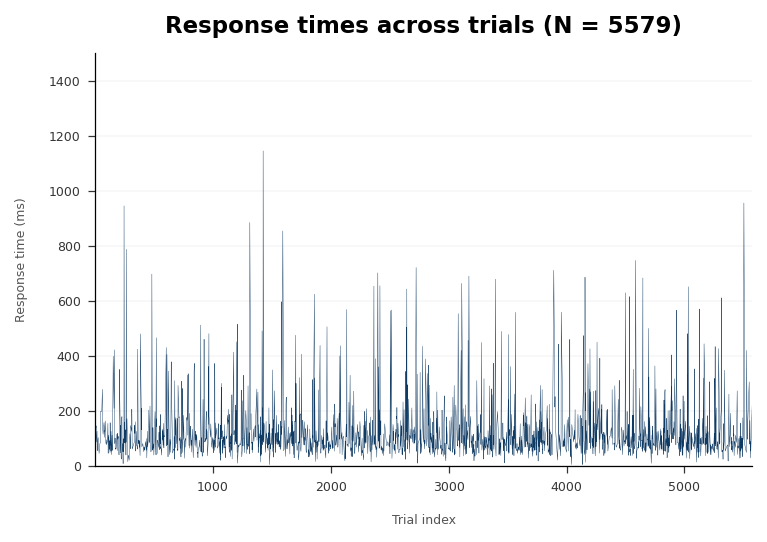

In [235]:
# load_data()
plt.figure(figsize=FIGURE_SIZE)

downscaled = results.sample(min(len(results), 2000)).sort_index()
plt.plot(
    downscaled.index, 
    downscaled["response_time"],
    linewidth = 0.2,
)
plt.title(f"Response times across trials (N = {len(results)})")
plt.xlabel("Trial index")
plt.ylabel("Response time (ms)")
plt.ylim((0, 1500))
plt.show()

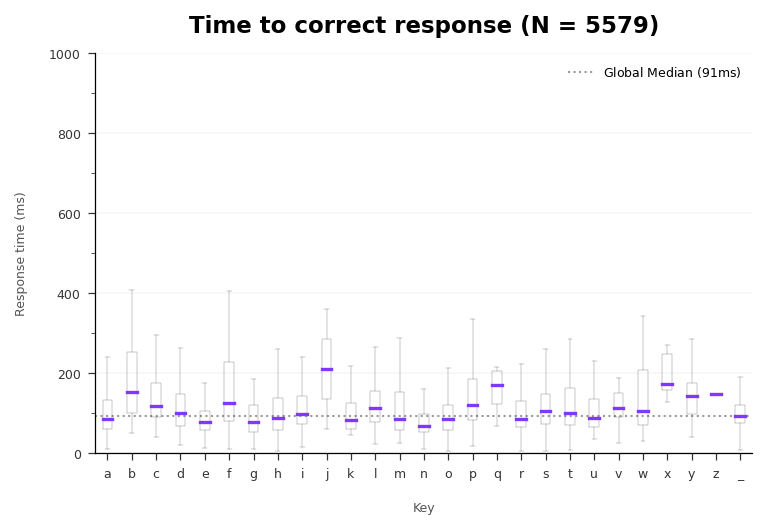

In [236]:
# load_data()
plt.figure(figsize=FIGURE_SIZE)
time_to_type = results.groupby(["session", "block", "cursor_position", "target_response"])["response_time"].sum().reset_index()

for key, data in time_to_type.groupby("target_response"):
    outlines_alpha = 0.5
    plt.boxplot(
        data["response_time"],
        positions=[ord(ALPHABET[0]) + len(ALPHABET) - 1] if key == SPACEBAR else [ord(key)],
        widths = 0.4,
        boxprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        whiskerprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        capprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        flierprops = dict(marker = "o", markersize = 1, alpha = outlines_alpha, markeredgecolor = "none"),
        medianprops = dict(linewidth = 1.6, color = "C2"),
    )
plt.axhline(
    y = time_to_type["response_time"].median(),
    linestyle = ":",
    linewidth = 1,
    color = "black",
    alpha = 0.4,
    zorder = -1,
    label = f"""Global Median (${time_to_type["response_time"].median():.0f}$ms)"""
)
plt.legend(loc = "upper right")
plt.suptitle("")
plt.title(f"Time to correct response (N = {len(results)})")
plt.xlabel("Key")
plt.ylabel("Response time (ms)")
plt.xticks(range(ord(ALPHABET[0]), ord(ALPHABET[0]) + len(ALPHABET)), ALPHABET)
plt.yticks(range(0, 1000, 100))
plt.ylim((0, 1000))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(200))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(100))
plt.show()
# plt.savefig(EXPORT_PATH.joinpath("relative_difficulty_per_key.png"), dpi = 300)

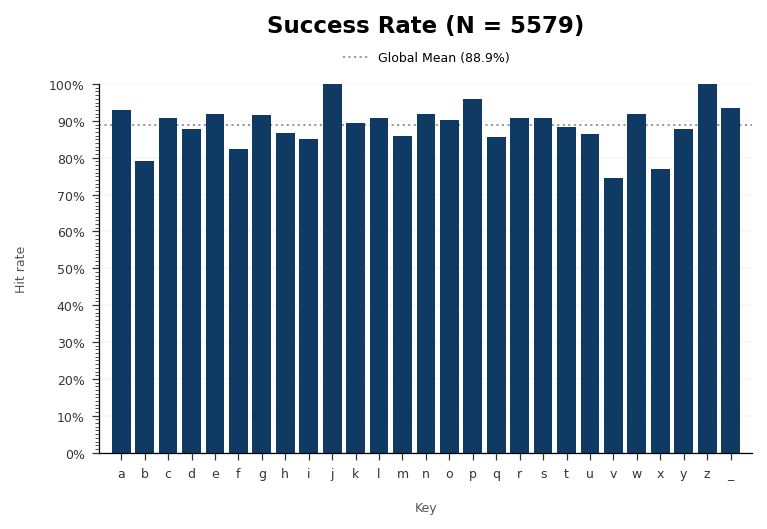

In [237]:
# load_data()
plt.figure(figsize=FIGURE_SIZE)
succes_rates = results.groupby("target_response").apply(lambda where_target: (where_target["response"] == where_target.name).mean())
# 1 - results[results["response"] != results["target_response"]]["response"].value_counts(normalize = True)

plt.bar(
    succes_rates.index.to_series().apply(lambda key: ord(ALPHABET[0]) + len(ALPHABET) - 1 if key == "_" else ord(key)), 
    succes_rates,
)

plt.axhline(
    y = succes_rates.mean(),
    linestyle = ":",
    linewidth = 1,
    color = "black",
    alpha = 0.4,
    zorder = -1,
    label = f"""Global Mean ({succes_rates.mean():.1%})"""
)
plt.legend(loc = "upper center", bbox_to_anchor = (0.5, 1.12))
plt.title(f"Success Rate (N = {len(results)})", pad = 25)
plt.suptitle("")
plt.xlabel("Key")
plt.ylabel("Hit rate")
plt.xticks(range(ord(ALPHABET[0]), ord(ALPHABET[0]) + len(ALPHABET)), ALPHABET)
plt.margins(x = 0.02)
plt.ylim((0, 1))
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
plt.show()
# plt.savefig(EXPORT_PATH.joinpath("hit_rate_per_key.png"), dpi = 300)

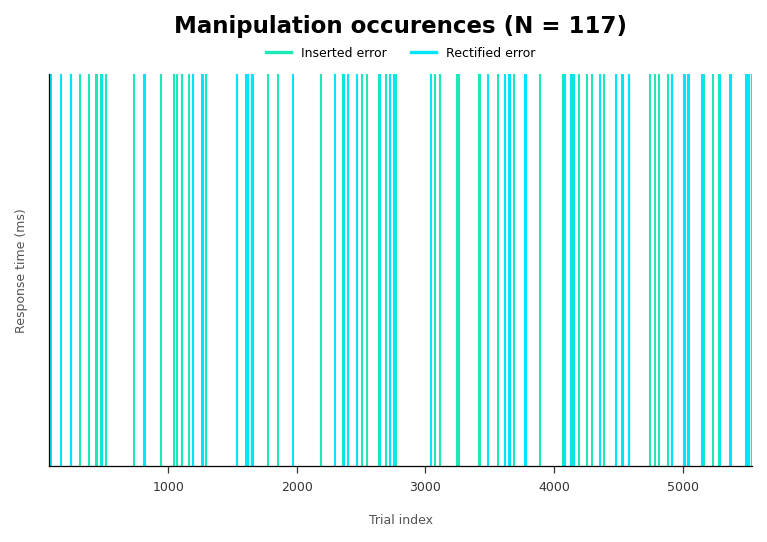

In [238]:
# load_data()
plt.figure(figsize=FIGURE_SIZE)

inserted_error_trials = results[(results["response"] == results["target_response"]) & (results["feedback"] == "negative")]
plt.plot([], [], color = "C3", label = "Inserted error")
for idx in inserted_error_trials.index:
    plt.axvline(idx, color = "C3", linewidth = 1)
rectified_error_trials = results[(results["response"] != results["target_response"]) & (results["feedback"] == "positive")]
plt.plot([], [], color = "C5", label = "Rectified error")
for idx in rectified_error_trials.index:
    plt.axvline(idx, color = "C5", linewidth = 1)

plt.title(f"Manipulation occurences (N = {len(inserted_error_trials) + len(rectified_error_trials)})", pad = 20)
plt.xlabel("Trial index")
plt.ylabel("Response time (ms)")
plt.yticks([])
plt.legend(loc = "upper center", bbox_to_anchor = (0.5, 1.1), ncol = 2)
plt.show()

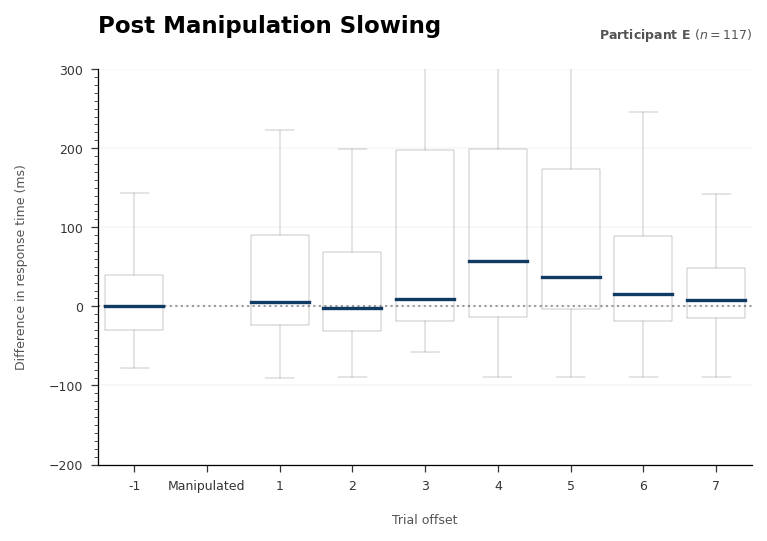

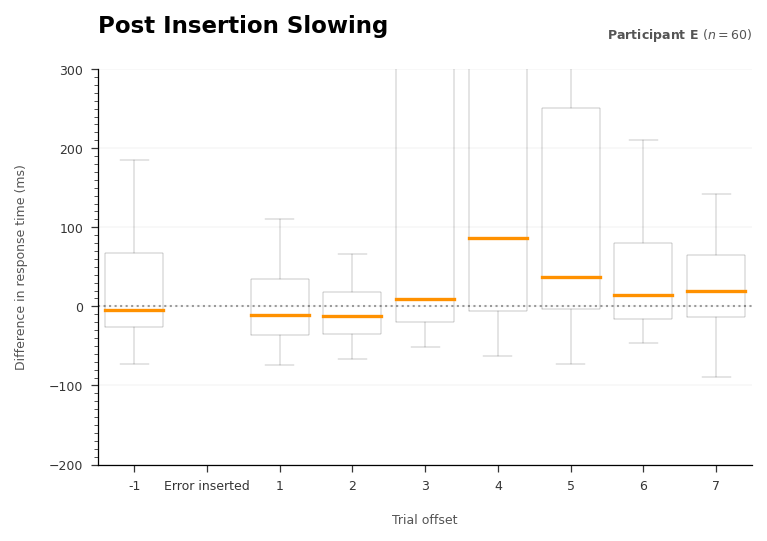

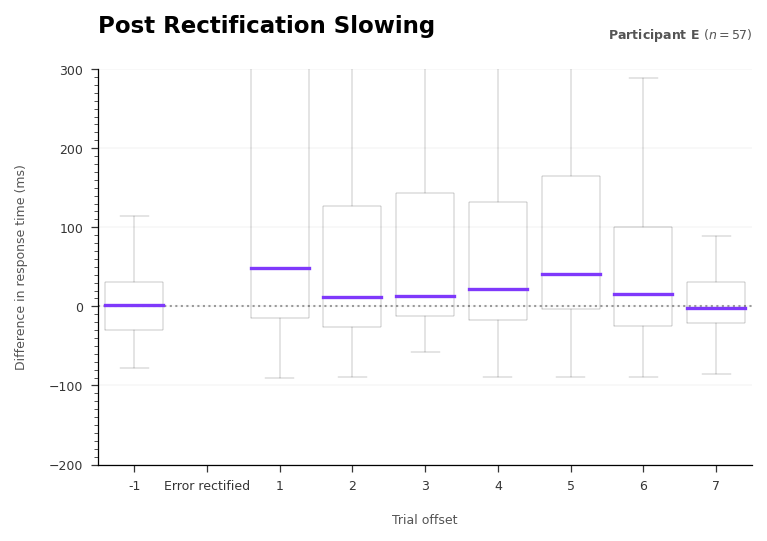

In [239]:
manipulated = results[results["condition"].isin(("error inserted", "error rectified"))]
immediately_preceding_manipulations = results["response_time"].loc[[trial_idx - 1 for trial_idx in manipulated.index]]

conditions = {
    "Post Manipulation Slowing": "manipulated",
    "Post Insertion Slowing": "error inserted",
    "Post Rectification Slowing": "error rectified",
}

for condition_index, (title, condition) in enumerate(conditions.items()):
    plt.figure(figsize=FIGURE_SIZE)
    trials = manipulated if condition == "manipulated" else results[results["condition"] == condition]
    offset_range = range(-1, 8)
    for trial_offset in offset_range:
        if trial_offset == 0:
            continue
        response_times = results["response_time"].loc[[trial_idx + trial_offset for trial_idx in trials.index if trial_idx + trial_offset in results.index.values]]
        outlines_alpha = 0.5
        plt.boxplot(
            response_times - immediately_preceding_manipulations.median(),
            positions=[trial_offset],
            widths = 0.8,
            boxprops = dict(linewidth = 0.2, alpha = outlines_alpha),
            whiskerprops = dict(linewidth = 0.2, alpha = outlines_alpha),
            capprops = dict(linewidth = 0.2, alpha = outlines_alpha),
            flierprops = dict(marker = "o", markersize = 1, alpha = outlines_alpha, markeredgecolor = "none"),
            medianprops = dict(linewidth = 1.6, color = f"C{condition_index}"),
        )
    plt.axhline(
        y = 0,
        linestyle = ":",
        linewidth = 1,
        color = "black",
        alpha = 0.4,
        zorder = -1,
    )
    plt.xticks(offset_range, [condition.capitalize() if offset == 0 else offset for offset in offset_range])
    plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(10))

    plt.title(title, x = 0, ha = "left", y = 1.04)
    plt.annotate(
        f"Participant {selected_participant.upper()} $(n = {len(trials)})$",
        xy = (1, 0.98),
        xycoords = ("axes fraction", "figure fraction"),
        fontweight = "bold",
        color = "#545454",
        ha = "right",
        va = "top"
    )
    plt.xlabel("Trial offset")
    plt.ylabel("Difference in response time (ms)")
    plt.ylim((-200, 300))
    plt.show()
    # plt.savefig(EXPORT_PATH.joinpath(f"{title}.png"), dpi = 300)


In [240]:
conditions = {
    "Genuinely Incorrect": "incorrect",
    "Inserted Error": "error inserted",
    "Rectified Error": "error rectified",
}

offset_range = range(-1, 6 + 1)
out = []
for condition in conditions.values():
    trial_indices = results[results["condition"] == condition].index
    for occurence in trial_indices:
        selection = results.loc[[occurence + trial_offset for trial_offset in offset_range if occurence + trial_offset in results.index]]
        selection["elicited_by"] = condition
        selection["condition_occurence"] = results.loc[occurence, "condition_occurence"]
        selection["baseline_trial"] = results.loc[occurence, "trial"]
        selection["offset"] = selection["trial"] - selection["baseline_trial"]
        out.append(selection[["elicited_by", "trial", "baseline_trial", "offset", "response_time", "condition_change", "condition_occurence"]])
    # for trial_offset in offset_range:
    #     selection = results.loc[[occurence + trial_offset for occurence in trial_indices if occurence + trial_offset in results.index]]
    #     selection["elicited_by"] = condition
    #     selection["offset"] = trial_offset
    #     out.append(selection[["session", "trial", "elicited_by", "offset", "response_time", "condition_change", "condition_occurence"]])

df = pd.concat(out)
df

,elicited_by,trial,baseline_trial,offset,response_time,condition_change,condition_occurence
46,incorrect,47,48,-1,197.5649,False,1
47,incorrect,48,48,0,221.1579,True,1
48,incorrect,49,48,1,487.4973,True,1
49,incorrect,50,48,2,221.6079,False,1
50,incorrect,51,48,3,175.4809,False,1
...,...,...,...,...,...,...,...
5517,error rectified,205,203,2,196.4171,True,49
5518,error rectified,206,203,3,389.8602,False,49
5519,error rectified,207,203,4,381.8686,False,49
5520,error rectified,208,203,5,71.5353,True,49


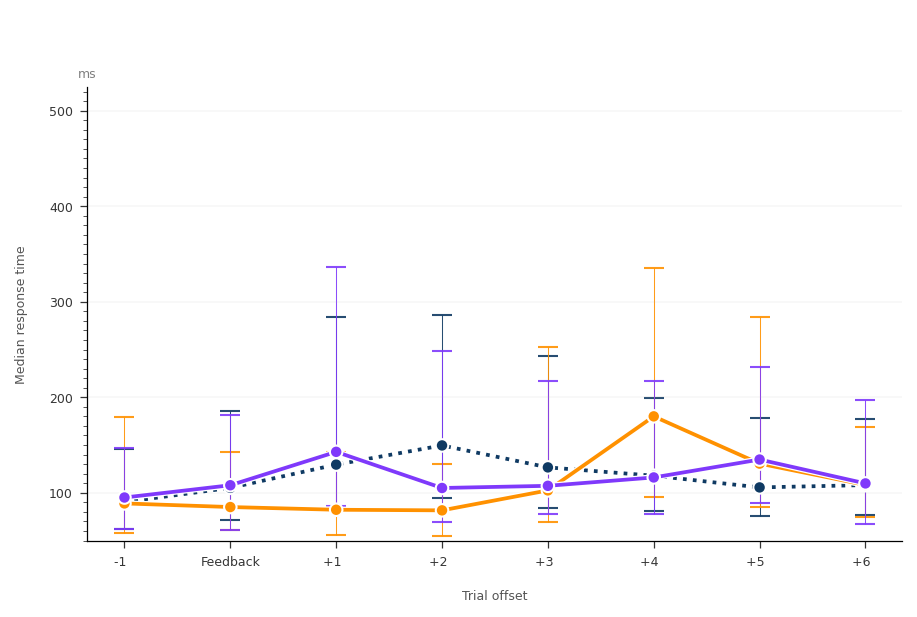

In [241]:
fig, ax = plt.subplots(figsize = (6, 4))

ax.annotate(
    "ms",
    xy = (0, 1.02),
    xycoords = "axes fraction",
    ha = "center",
    alpha = 0.5,
)

for condition_index, (title, condition) in enumerate(conditions.items()):
    trials = df[df["elicited_by"] == condition]
    agg = []
    for trial_offset in offset_range:
        response_times = trials[trials["offset"] == trial_offset]["response_time"]
        params = stats.lognorm.fit(response_times)
        agg.append(dict(
            offset = trial_offset, 
            median = response_times.median(),
            mean = response_times.mean(),
            lower = stats.lognorm.interval(0.5, *params)[0],
            upper = stats.lognorm.interval(0.5, *params)[1],
        ))

    agg = pd.DataFrame.from_records(agg)
    
    ax.plot(
        agg["offset"],
        agg["median"],
        marker = "o",
        markersize = 4,
        linewidth = 1.8,
        color = f"C{condition_index}",
        linestyle = "dotted" if condition == "incorrect" else "solid",
        path_effects = [patheffects.Stroke(linewidth = 3, foreground = "white"), patheffects.Normal()],
        label = f"""{title} ({len(results[results["condition"] == condition])} instances)""",
    )
    ax.errorbar(
        agg["offset"],
        agg["median"],
        yerr = (agg["median"] - agg["lower"], agg["upper"] - agg["median"]),
        fmt = "none",
        alpha = 0.9,
        color = f"C{condition_index}",
        elinewidth = 0.5,
        capsize = 5,
        zorder = -1,
    )

    ax.xaxis.set_major_formatter(lambda val, idx: "Feedback" if val == 0 else f"{val:+.0f}  ")
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))
    ax.margins(x = 0.05)

    ax.set_xlabel("Trial offset")
    ax.set_ylabel("Median response time")
    ax.set_ylim((50, 525))
    ax.legend(
        handles = [lines.Line2D([0], [0], color="white")] * 3,
        labels = [""] * 3,
        loc = "lower right", 
        bbox_to_anchor = (1, 1.01),
    )
    # ax.legend(
    #     loc = "lower right", 
    #     bbox_to_anchor = (1, 1.01),
    # )

plt.show()

/tmp/ipykernel_1060/1331379476.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials["cumsum"] = trials.groupby(["elicited_by", "baseline_trial", "condition_occurence"])["response_time"].cumsum()
/tmp/ipykernel_1060/1331379476.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials["cumsum"] = trials.groupby(["elicited_by", "baseline_trial", "condition_occurence"])["response_time"].cumsum()
/tmp/ipykernel_1060/1331379476.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

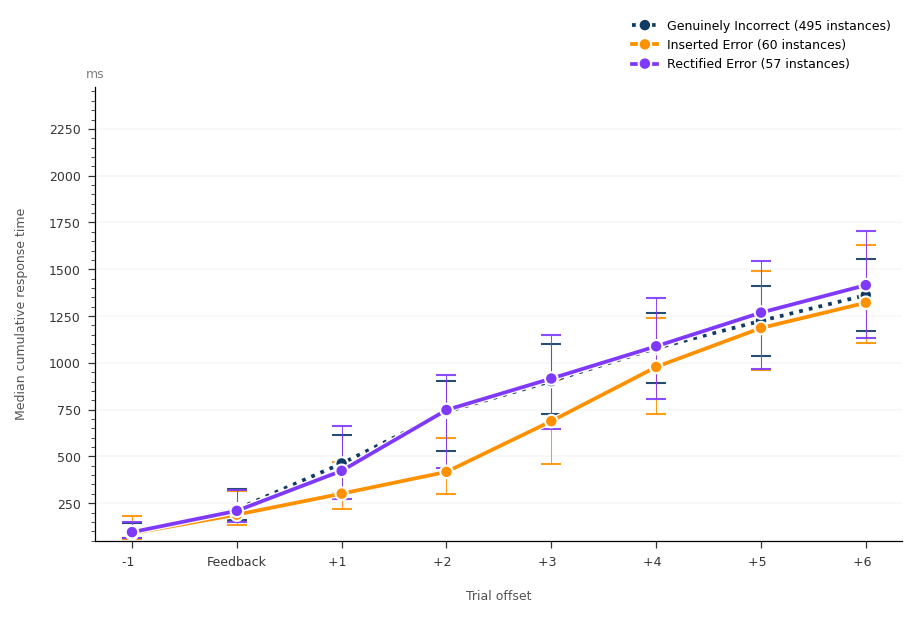

In [242]:
fig, ax = plt.subplots(figsize = (6, 4))

ax.annotate(
    "ms",
    xy = (0, 1.02),
    xycoords = "axes fraction",
    ha = "center",
    alpha = 0.5,
)

for condition_index, (title, condition) in enumerate(conditions.items()):
    trials = df[df["elicited_by"] == condition]
    trials["cumsum"] = trials.groupby(["elicited_by", "baseline_trial", "condition_occurence"])["response_time"].cumsum()
    # print(trials[["trial", "elicited_by", "condition_occurence", "offset", "response_time", "cumsum"]])
    agg = []
    for trial_offset in offset_range:
        response_times = trials[trials["offset"] == trial_offset]["cumsum"]
        params = stats.lognorm.fit(response_times)
        agg.append(dict(
            offset = trial_offset, 
            median = response_times.median(),
            mean = response_times.mean(),
            std = response_times.std(),
            lower = stats.lognorm.interval(0.5, *params)[0],
            upper = stats.lognorm.interval(0.5, *params)[1],
        ))

    agg = pd.DataFrame.from_records(agg)
    
    ax.plot(
        agg["offset"],
        agg["median"],
        marker = "o",
        markersize = 4,
        linewidth = 1.8,
        color = f"C{condition_index}",
        linestyle = "dotted" if condition == "incorrect" else "solid",
        path_effects = [patheffects.Stroke(linewidth = 3, foreground = "white"), patheffects.Normal()],
        label = f"""{title} ({len(results[results["condition"] == condition])} instances)""",
    )
    ax.errorbar(
        agg["offset"],
        agg["median"],
        # yerr = agg["std"],
        yerr = (agg["median"] - agg["lower"], agg["upper"] - agg["median"]),
        fmt = "none",
        alpha = 0.9,
        color = f"C{condition_index}",
        elinewidth = 0.5,
        capsize = 5,
        zorder = -1,
    )

    ax.xaxis.set_major_formatter(lambda val, idx: "Feedback" if val == 0 else f"{val:+.0f}  ")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(250))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))
    ax.margins(x = 0.05)

    ax.set_xlabel("Trial offset")
    ax.set_ylabel("Median cumulative response time")
    ax.set_ylim((50, 2475))
    # ax.legend(
    #     handles = [lines.Line2D([0], [0], color="white")] * 3,
    #     labels = [""] * 3,
    #     loc = "lower right", 
    #     bbox_to_anchor = (1, 1.01),
    # )
    ax.legend(
        loc = "lower right", 
        bbox_to_anchor = (1, 1.01),
    )

plt.show()

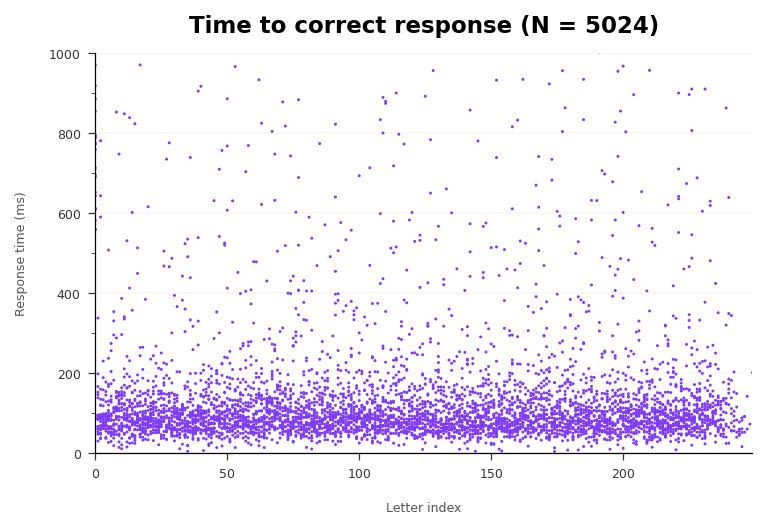

In [243]:
# load_data()
plt.figure(figsize=FIGURE_SIZE)
plt.scatter(
    time_to_type["cursor_position"], 
    time_to_type["response_time"],
    marker = "o",
    s = 2,
    color = "C2",
    edgecolor = "none",
)
plt.suptitle("")
plt.title(f"Time to correct response (N = {len(time_to_type)})")
plt.xlabel("Letter index")
plt.ylabel("Response time (ms)")
plt.yticks(range(0, 1000, 100))
plt.ylim((0, 1000))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(200))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(100))
plt.show()

In [244]:
# conditions = {
#     # "Genuinely Correct": "correct",
#     "Genuinely Incorrect": "incorrect",
#     "Inserted Error": "error inserted",
#     "Rectified Error": "error rectified",
# }
# offset_range = range(-1, 7)

# out = []
# for session in "abcdez":
#     selected_participant = session
#     LOG_FILENAME = f"group13_{selected_participant}.csv"
#     load_data()

#     for condition_index, (title, condition) in enumerate(conditions.items()):
#         trial_indices = results[results["condition"] == condition].index
#         for offset in offset_range:
#             selection = results.loc[[occurence + offset for occurence in trial_indices if occurence + offset in results.index]]
#             selection["elicited_by"] = condition
#             selection["offset"] = offset
#             selection["session"] = session
#             # print(len(selection))
#             out.append(selection[["session", "trial", "elicited_by", "offset", "response_time", "condition_change", "condition_occurence"]])

# df = pd.concat(out)
# df.to_csv("../data/behavioural/post_manipulation_slowing.csv", index = False)